In [37]:
# 適宜自分のApplicationPATHまで変更
APP_PATH = '/root'
# APP_PATH = '.'


# 標準モジュール(install不要)
import os
import math
import random
import pdb          # デバッグ用


# import time
# import copy
# from collections import defaultdict
import torch
# import shutil
# import pandas as pd
from skimage import io, transform # scikit-image
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils # 現時点では使ってない
from torch import nn
import albumentations as alb
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm as tqdm

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
# import zipfile


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

TRAIN_PATH = APP_PATH + '/data/img'
CHECKPOINT_PATH = APP_PATH + '/data/model'
CHECKPOINT_PATH_UNet = CHECKPOINT_PATH + '/UNet'

# os.chdir(APP_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
exec pwd
/content/drive/Othercomputers/LAPTOP-3BHDM0TI/windows_research/workspace/research/carbon-steel-tissue-analysis
exec ls al
total 41
drwx------ 2 root root 4096 May 24 09:49 app
drwx------ 2 root root 4096 May 24 09:49 bin
drwx------ 4 root root 4096 May 24 09:52 data
drwx------ 2 root root 4096 May 27 10:23 .git
-rw------- 1 root root 3338 May 27 11:29 .gitignore
drwx------ 2 root root 4096 Jun  1 12:40 lib
-rw------- 1 root root  265 May  8 09:51 Makefile
drwx------ 2 root root 4096 May 27 10:32 memo
drwx------ 2 root root 4096 Jun  1 12:48 module
-rw------- 1 root root  410 May 27 11:23 README.md
drwx------ 2 root root 4096 May 25 11:02 stage1_train
drwx------ 2 root root 4096 May 24 00:57 tmp


In [49]:
# ファイルの実行(ノートブック側でランタイムの再接続 or reloadをする)
# importで実行するときはファイルのパスを通す必要がある
# sys.path.append(APP_PATH + '/bin')

# setupなどのOSに関するコマンド実行はその定義ファイルをコマンドで実行
# 関数などのモジュールはimportで扱えるようにして実行
# !python bin/setup.py

# はじめから256にresizeされている
IMG_HEIGHT = 256
IMG_WIDTH = 256

NUM_EPOCHS = 300
# NUM_EPOCHS = 5

In [39]:
#画像データ拡張の関数
def get_train_transform():
    
   return alb.Compose(
       [
        #リサイズ(元画像ですでにしているが)
        alb.Resize(IMG_HEIGHT, IMG_WIDTH),
        #正規化(こちらの細かい値はalbumentations.augmentations.transforms.Normalizeのデフォルトの値を適用)
        alb.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        #水平フリップ（pはフリップする確率）
        alb.HorizontalFlip(p=0.25),
        #垂直フリップ
        alb.VerticalFlip(p=0.25),
        ToTensorV2(),
        ])

#Datasetクラスの定義
class LoadDataSet(Dataset):
        def __init__(self, path, transform=None):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_train_transform()
        
        def __len__(self):
            return len(self.folders)

        def __getitem__(self, idx):
            image_folder = os.path.join(self.path, self.folders[idx], 'images/')
            mask_folder = os.path.join(self.path, self.folders[idx], 'masks/')
            image_path = os.path.join(image_folder, os.listdir(image_folder)[0])
            
            # debug
            # print(f'image_folder: {image_folder}')
            # print(f'mask_folder: {mask_folder}')
            # print(f'image_path: {image_path}')
            # print(f'mask_path: {mask_path}')
            
            #画像データの取得
            # 3次元の処理を2次元に変更するのがいろいろめんどくさいから3次元の型で扱うことにする
            ## exec img
            # img = io.imread(image_path)[:,:,:3].astype('float32')
            img = io.imread(image_path)
            # TODO: 正答率がでたら比較としてfloat32でも試してみる
            # print(f'2d img.shape: {img.shape}') # 白黒なのでチャネル数が省略されて2次元データになっている
            img = self.conv_2D_to_3Darray(img)
            # print(f'3d img.shape: {img.shape}')


            ## exec mask
            # img = transform.resize(img,(256,256))
            ## mask = io.imread(mask_path)
            # maskの量が2つ以上になったらここの関数を実行してすべてを得る
            # mask = self.get_mask(mask_folder, 256, 256).astype('float32')
            mask = self.get_mask(mask_folder, IMG_HEIGHT, IMG_WIDTH) # nint8でOK?
            # print(f'calced mask.shape: {mask.shape}')

            # 前処理をするためにひとつにまとめる
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            return (img,mask)
        
        def conv_2D_to_3Darray(self, arr):
            # print(f'exec conv_2D_to_3Darray')
            image = Image.fromarray(arr)
            image = image.convert("RGB")
            # 変換するならここでfloat32にする
            arr = np.asarray(image, np.uint8)
            # print(f'to3d arr shape: {arr.shape}')
            return arr

        def conv_3D_to_2Darray(self, arr):
            # print(f'exec conv_3D_to_2Darray')
            image = Image.fromarray(arr)
            image = image.convert("L")
            arr = np.asarray(image, np.uint8) # 変換するならここでfloat32にする
            # print(f'to2d arr shape: {arr.shape}')
            # arr = np.transpose(arr, (2, 0, 1))
            # print(f'arr transpose shape: {arr.shape}')
            return arr

        #マスクデータの取得
        def get_mask(self, mask_folder, IMG_HEIGHT, IMG_WIDTH):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
            # print(f'len(os.listdir(mask_folder)): {len(os.listdir(mask_folder))}')
            for mask_ in os.listdir(mask_folder):
                    mask_ = io.imread(os.path.join(mask_folder,mask_))
                    # RGBからLへ
                    mask_ = self.conv_3D_to_2Darray(mask_)
                    mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
                    mask_ = np.expand_dims(mask_,axis=-1)
                    mask = np.maximum(mask, mask_)

            return mask

# データセットを確認する
train_dataset = LoadDataSet(TRAIN_PATH, transform=get_train_transform())


# 辞書型のときに要素を取得するマジックメソッド　以下と同じ意味
# image, mask = train_dataset.__getitem__(0)
image, mask = train_dataset[0]
print(image.shape)
print(mask.shape)

#Print total number of unique images.
# フォルダーの長さを表示　以下と同じ意味
train_dataset.__len__()
print(len(train_dataset))


torch.Size([3, 256, 256])
torch.Size([256, 256, 1])
60


[39, 13, 5]


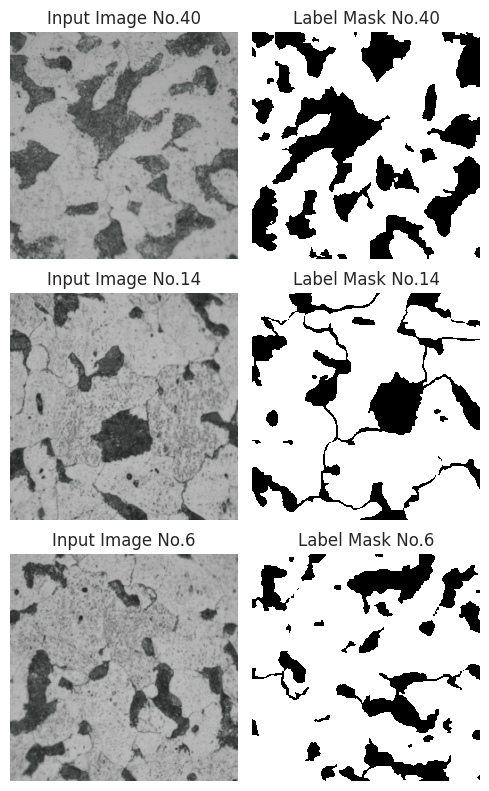

In [40]:
def format_image(img):
    img = np.array(np.transpose(img, (1,2,0)))
    #下は画像拡張での正規化を元に戻しています
    mean=np.array((0.485, 0.456, 0.406))
    std=np.array((0.229, 0.224, 0.225))
    img  = std * img + mean
    img = img*255
    img = img.astype(np.uint8)
    return img

def format_mask(mask):
    mask = np.squeeze(np.transpose(mask, (1,2,0)))
    return mask

def visualize_dataset(n_images, num_range, predict=None):
    #TODO:表示時に水平・垂直クリップがかるからかからないようにする(Predictedのほうも)
    images = random.sample(range(0, num_range), n_images)
    figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5, 8))
    print(images)
    for i in range(0, len(images)):
        img_no = images[i]
        image, mask = train_dataset[i]
        image = format_image(image)
        mask = format_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest", cmap="gray")
        ax[i, 0].set_title(f"Input Image No.{img_no+1}")
        ax[i, 1].set_title(f"Label Mask No.{img_no+1}")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

num_range = len(train_dataset)
visualize_dataset(3, num_range)

In [41]:
split_ratio = 0.25
train_size=int(np.round(train_dataset.__len__()*(1 - split_ratio),0))
valid_size=int(np.round(train_dataset.__len__()*split_ratio,0))
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(dataset=valid_data, batch_size=10)

print("Length of train　data: {}".format(len(train_data)))
print("Length of validation　data: {}".format(len(valid_data)))

Length of train　data: 45
Length of validation　data: 15


In [42]:
# UNet
class UNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        # 資料中の『FCN』に当たる部分
        self.conv1 = conv_bn_relu(input_channels,64)
        self.conv2 = conv_bn_relu(64, 128)
        self.conv3 = conv_bn_relu(128, 256)
        self.conv4 = conv_bn_relu(256, 512)
        self.conv5 = conv_bn_relu(512, 1024)
        self.down_pooling = nn.MaxPool2d(2)

        # 資料中の『Up Sampling』に当たる部分
        self.up_pool6 = up_pooling(1024, 512)
        self.conv6 = conv_bn_relu(1024, 512)
        self.up_pool7 = up_pooling(512, 256)
        self.conv7 = conv_bn_relu(512, 256)
        self.up_pool8 = up_pooling(256, 128)
        self.conv8 = conv_bn_relu(256, 128)
        self.up_pool9 = up_pooling(128, 64)
        self.conv9 = conv_bn_relu(128, 64)
        self.conv10 = nn.Conv2d(64, output_channels, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        # 正規化
        x = x/255.

        # 資料中の『FCN』に当たる部分
        x1 = self.conv1(x)
        p1 = self.down_pooling(x1)
        x2 = self.conv2(p1)
        p2 = self.down_pooling(x2)
        x3 = self.conv3(p2)
        p3 = self.down_pooling(x3)
        x4 = self.conv4(p3)
        p4 = self.down_pooling(x4)
        x5 = self.conv5(p4)

        # 資料中の『Up Sampling』に当たる部分, torch.catによりSkip Connectionをしている
        p6 = self.up_pool6(x5)
        x6 = torch.cat([p6, x4], dim=1)
        x6 = self.conv6(x6)

        p7 = self.up_pool7(x6)
        x7 = torch.cat([p7, x3], dim=1)
        x7 = self.conv7(x7)

        p8 = self.up_pool8(x7)
        x8 = torch.cat([p8, x2], dim=1)
        x8 = self.conv8(x8)

        p9 = self.up_pool9(x8)
        x9 = torch.cat([p9, x1], dim=1)
        x9 = self.conv9(x9)

        output = self.conv10(x9)
        output = torch.sigmoid(output)

        return output

#畳み込みとバッチ正規化と活性化関数Reluをまとめている
def conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
    )

def down_pooling():
    return nn.MaxPool2d(2)

def up_pooling(in_channels, out_channels, kernel_size=2, stride=2):
    return nn.Sequential(
        #転置畳み込み
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )



In [43]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        
        return 1 - dice


In [44]:
class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return IoU

In [50]:
#<---------------各インスタンス作成---------------------->
model = UNet(3,1).cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
criterion = DiceLoss()
accuracy_metric = IoU()

valid_loss_min = np.Inf

best_model_file = '/best_model.pth'

total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []

losses_value = 0
for epoch in range(NUM_EPOCHS):
  #<---------------トレーニング---------------------->
    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    pbar = tqdm(train_loader, desc = 'description')
    for x_train, y_train in pbar:
      x_train = torch.autograd.Variable(x_train).cuda()
      y_train = torch.autograd.Variable(y_train).cuda()
      optimizer.zero_grad()
      output = model(x_train)
      ## 損失計算
      loss = criterion(output, y_train)
      losses_value = loss.item()
      ## 精度評価
      score = accuracy_metric(output,y_train)
      loss.backward()
      optimizer.step()
      train_loss.append(losses_value)
      train_score.append(score.item())
      pbar.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")
    #<---------------評価---------------------->
    with torch.no_grad():
      for image,mask in val_loader:
        image = torch.autograd.Variable(image).cuda()
        mask = torch.autograd.Variable(mask).cuda()
        output = model(image)
        ## 損失計算
        loss = criterion(output, mask)
        losses_value = loss.item()
        ## 精度評価
        score = accuracy_metric(output,mask)
        valid_loss.append(losses_value)
        valid_score.append(score.item())

    total_train_loss.append(np.mean(train_loss))
    total_train_score.append(np.mean(train_score))
    total_valid_loss.append(np.mean(valid_loss))
    total_valid_score.append(np.mean(valid_score))
    print(f"Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}")
    print(f"Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}")

    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': total_valid_loss[-1],
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    ## 容量をとるので必要になったら保存する
    # checkpoint_file = "/checkpoint_{}_weight.pth".format(epoch+1)
    # checkpointの保存
    # torch.save(checkpoint, CHECKPOINT_PATH_UNet + checkpoint_file)
    
    # 評価データにおいて最高精度のモデルのcheckpointの保存
    if total_valid_loss[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,total_valid_loss[-1]))
        torch.save(checkpoint, CHECKPOINT_PATH_UNet + best_model_file)
        valid_loss_min = total_valid_loss[-1]

    print("")
    


Epoch: 1, loss: 0.0977108711772755, IoU: 0.8219737808314153: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train Loss: 0.2332404521301889, Train IOU: 0.6594514248720118
Valid Loss: 0.08517081626372269, Valid IOU: 0.8434029373615619
Validation loss decreased (inf --> 0.085171).  Saving model ...



Epoch: 2, loss: 0.09347516830504998, IoU: 0.829031420543635: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Train Loss: 0.09897967673807422, Train IOU: 0.8203576407587228
Valid Loss: 0.07511723048944319, Valid IOU: 0.8606812690872842
Validation loss decreased (0.085171 --> 0.075117).  Saving model ...



Epoch: 3, loss: 0.12030812518817091, IoU: 0.7852236678960721: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Train Loss: 0.0802457370648599, Train IOU: 0.8523519617033672
Valid Loss: 0.07443186997367113, Valid IOU: 0.8619086268857976
Validation loss decreased (0.075117 --> 0.074432).  Saving model ...



Epoch: 4, loss: 0.055594764399822805, IoU: 0.8946666875682239: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Train Loss: 0.07546603035711122, Train IOU: 0.862334416068698
Valid Loss: 0.06331297358915033, Valid IOU: 0.8811620432003267
Validation loss decreased (0.074432 --> 0.063313).  Saving model ...



Epoch: 5, loss: 0.06424614782753668, IoU: 0.8792647948355014: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Train Loss: 0.06979465623709702, Train IOU: 0.8705973953651872
Valid Loss: 0.061097874983048917, Valid IOU: 0.8851412173510904
Validation loss decreased (0.063313 --> 0.061098).  Saving model ...



Epoch: 6, loss: 0.0712775052658815, IoU: 0.8669302343722932: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Train Loss: 0.07015812463476767, Train IOU: 0.869511726002148
Valid Loss: 0.05633143509100186, Valid IOU: 0.8935077250036341
Validation loss decreased (0.061098 --> 0.056331).  Saving model ...



Epoch: 7, loss: 0.16033073707558965, IoU: 0.7236472270218677: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Train Loss: 0.07446653905402842, Train IOU: 0.8642809306868028
Valid Loss: 0.05863662450236701, Valid IOU: 0.8893937958875595



Epoch: 8, loss: 0.10754851023806333, IoU: 0.8057905137393793: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Train Loss: 0.06219563202220198, Train IOU: 0.8837791066957807
Valid Loss: 0.05779488729432736, Valid IOU: 0.8909297021800374



Epoch: 9, loss: 0.09886588879504954, IoU: 0.8200586891292663: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Train Loss: 0.082134468474332, Train IOU: 0.8496905148038341
Valid Loss: 0.05329407820679888, Valid IOU: 0.8990364595123427
Validation loss decreased (0.056331 --> 0.053294).  Saving model ...



Epoch: 10, loss: 0.03125746563974752, IoU: 0.9393800801635027: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Train Loss: 0.06239860830015833, Train IOU: 0.883755265564861
Valid Loss: 0.055922058427508026, Valid IOU: 0.894652502168914



Epoch: 11, loss: 0.06028553865336794, IoU: 0.8862845985984433: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Train Loss: 0.06010625254378619, Train IOU: 0.8868656420093733
Valid Loss: 0.06850606299749201, Valid IOU: 0.8718768165606876



Epoch: 12, loss: 0.0570546674755108, IoU: 0.8920499939138538: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Train Loss: 0.061497433102203944, Train IOU: 0.8845388199666481
Valid Loss: 0.05693977292730035, Valid IOU: 0.892661042912458



Epoch: 13, loss: 0.05016666832473404, IoU: 0.9044598649342955: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Train Loss: 0.06426131976325615, Train IOU: 0.8803840662510686
Valid Loss: 0.05544452012669698, Valid IOU: 0.8951525815856779



Epoch: 14, loss: 0.06310969735931782, IoU: 0.881273669455473: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Train Loss: 0.06339855778076049, Train IOU: 0.8808738038424064
Valid Loss: 0.05232888907221128, Valid IOU: 0.9009925209758258
Validation loss decreased (0.053294 --> 0.052329).  Saving model ...



Epoch: 15, loss: 0.048044799700178276, IoU: 0.9083155975299273: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Train Loss: 0.052096108356413026, Train IOU: 0.9011682164442398
Valid Loss: 0.0520720691156501, Valid IOU: 0.9012937382723811
Validation loss decreased (0.052329 --> 0.052072).  Saving model ...



Epoch: 16, loss: 0.06625037574511239, IoU: 0.875732404203805: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Train Loss: 0.05277655355854616, Train IOU: 0.8999995378052832
Valid Loss: 0.0513096015340227, Valid IOU: 0.902608896115922
Validation loss decreased (0.052072 --> 0.051310).  Saving model ...



Epoch: 17, loss: 0.1031291890500704, IoU: 0.8130246881883053: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train Loss: 0.06109946310524157, Train IOU: 0.8860694723549661
Valid Loss: 0.05216467777093803, Valid IOU: 0.9010860129381284



Epoch: 18, loss: 0.07945200667887076, IoU: 0.8527923407467964: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Train Loss: 0.05235156095601854, Train IOU: 0.9008297736372191
Valid Loss: 0.05380252873035246, Valid IOU: 0.8982433551814385



Epoch: 19, loss: 0.11433607142961733, IoU: 0.7947910658982473: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Train Loss: 0.06626111660648981, Train IOU: 0.8767103833032301
Valid Loss: 0.05113780202737134, Valid IOU: 0.9030647033987367
Validation loss decreased (0.051310 --> 0.051138).  Saving model ...



Epoch: 20, loss: 0.033383068563116125, IoU: 0.9353907949630202: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Train Loss: 0.05677606399628703, Train IOU: 0.8936103660317315
Valid Loss: 0.055983123601576756, Valid IOU: 0.894563836834229



<Figure size 640x480 with 0 Axes>

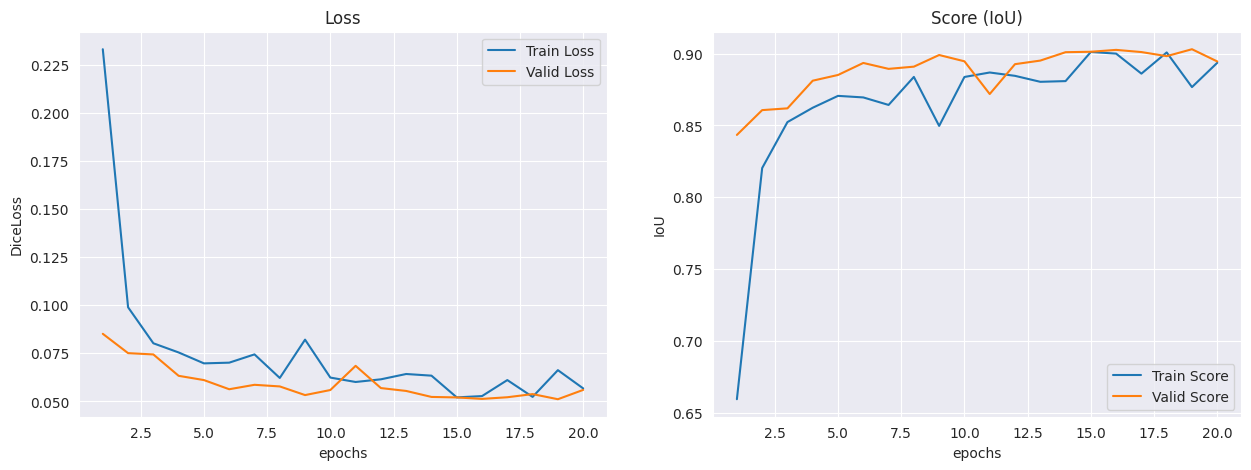

In [51]:
# # 数値の配列を文字列にして返す関数
# def convert_list_el_to_str_from_num(arr_num, num_decimals = 0):
#     arr_str = []
#     for num in arr_num:
#         if num_decimals == 0:
#             stg = str(num)
#         else:
#             stg = str(math.floor(num * 10 ** num_decimals) / (10 ** num_decimals))
#             while True:
#                 if not(stg[-1] in ["0", "."]):
#                     break
#                 elif stg == "0.0":
#                     stg = "0"
#                 else:
#                     stg = stg[:-1]

#         arr_str.append(stg)
#     return arr_str

def convert_list_el_to_str_from_num(arr_num, num_decimals = 0):
    print(arr_num)
    arr_str = []
    for num in arr_num:
        if num_decimals == 0:
            stg = str(num)
        else:
            num_foor = math.floor(num * 10 ** num_decimals) / (10 ** num_decimals)
            print('num_foor:' + str(num_foor))
            stg = str(num_foor)
            print('stg:' + stg)
            while True:
                if not(stg[-1] in ["0", "."]):
                    break
                elif stg == "0.0":
                    stg = "0"
                    break
                else:
                    stg = stg[:-1]
                # pdb.set_trace()
        
        print('append:' + stg)
        arr_str.append(stg)
    return arr_str



plt.figure(1)
plt.figure(figsize=(15,5))
# sns.set_style(style="darkgrid")

if NUM_EPOCHS < 20:
    arange_num = np.arange(1, NUM_EPOCHS+1, step=1)
    arange_str = convert_list_el_to_str_from_num(arange_num)

    # print(arange_str)
    plt.xticks(arange_num, arange_str)
    plt.xlim(1, NUM_EPOCHS)
elif NUM_EPOCHS < 60:
    plt.xticks(np.arange(1, NUM_EPOCHS+1, step=5))
    plt.xlim(0, NUM_EPOCHS)
else:
    plt.xticks(np.arange(1, NUM_EPOCHS+1, step=10))
    plt.xlim(0, NUM_EPOCHS)


plt.rcParams['font.family'] ='sans-serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams["font.size"] = 18
plt.rcParams['axes.linewidth'] = 1.0
# plt.minorticks_on()

# plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
# plt.gca().xaxis.get_major_formatter().set_useOffset(False)
# plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# plt.locator_params(axis='y',nbins=6)


plt.subplot(1, 2, 1)
arange_num = np.arange(0, 0.25+0.01, step=0.05)
# arange_str = convert_list_el_to_str_from_num(arange_num, 0)
# めんどくさいから自分で指定する
arange_str = ["0", "0.05", "0.1", "0.15", "0.2", "0.25"]
# print(arange_str)
plt.yticks(arange_num, arange_str)
plt.ylim(0, 0.25)
plt.minorticks_on()
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_valid_loss, label="Valid Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("DiceLoss")


plt.subplot(1, 2, 2)
arange_num = np.arange(0.6, 0.95+0.01, step=0.05)
# arange_str = convert_list_el_to_str_from_num(arange_num, 2)
arange_str = ["0.6", "0.65", "0.7", "0.75", "0.8", "0.85", "0.9", "0.95"]
# print(arange_str)
plt.yticks(arange_num, arange_str)
plt.ylim(0.6, 0.95)
plt.minorticks_on()
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_train_score, label="Train Score")
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_valid_score, label="Valid Score")
plt.title("Score (IoU)")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.show()


In [52]:
# bestmodelの読み込み
checkpoint = torch.load(CHECKPOINT_PATH_UNet + best_model_file)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
start_epoch = checkpoint['epoch']
valid_loss_min = checkpoint['valid_loss_min']

<ipython-input-53-ef301cb968f3>:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = torch.autograd.Variable(data, volatile=True).cuda()
<ipython-input-53-ef301cb968f3>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  mask = torch.autograd.Variable(mask, volatile=True).cuda()


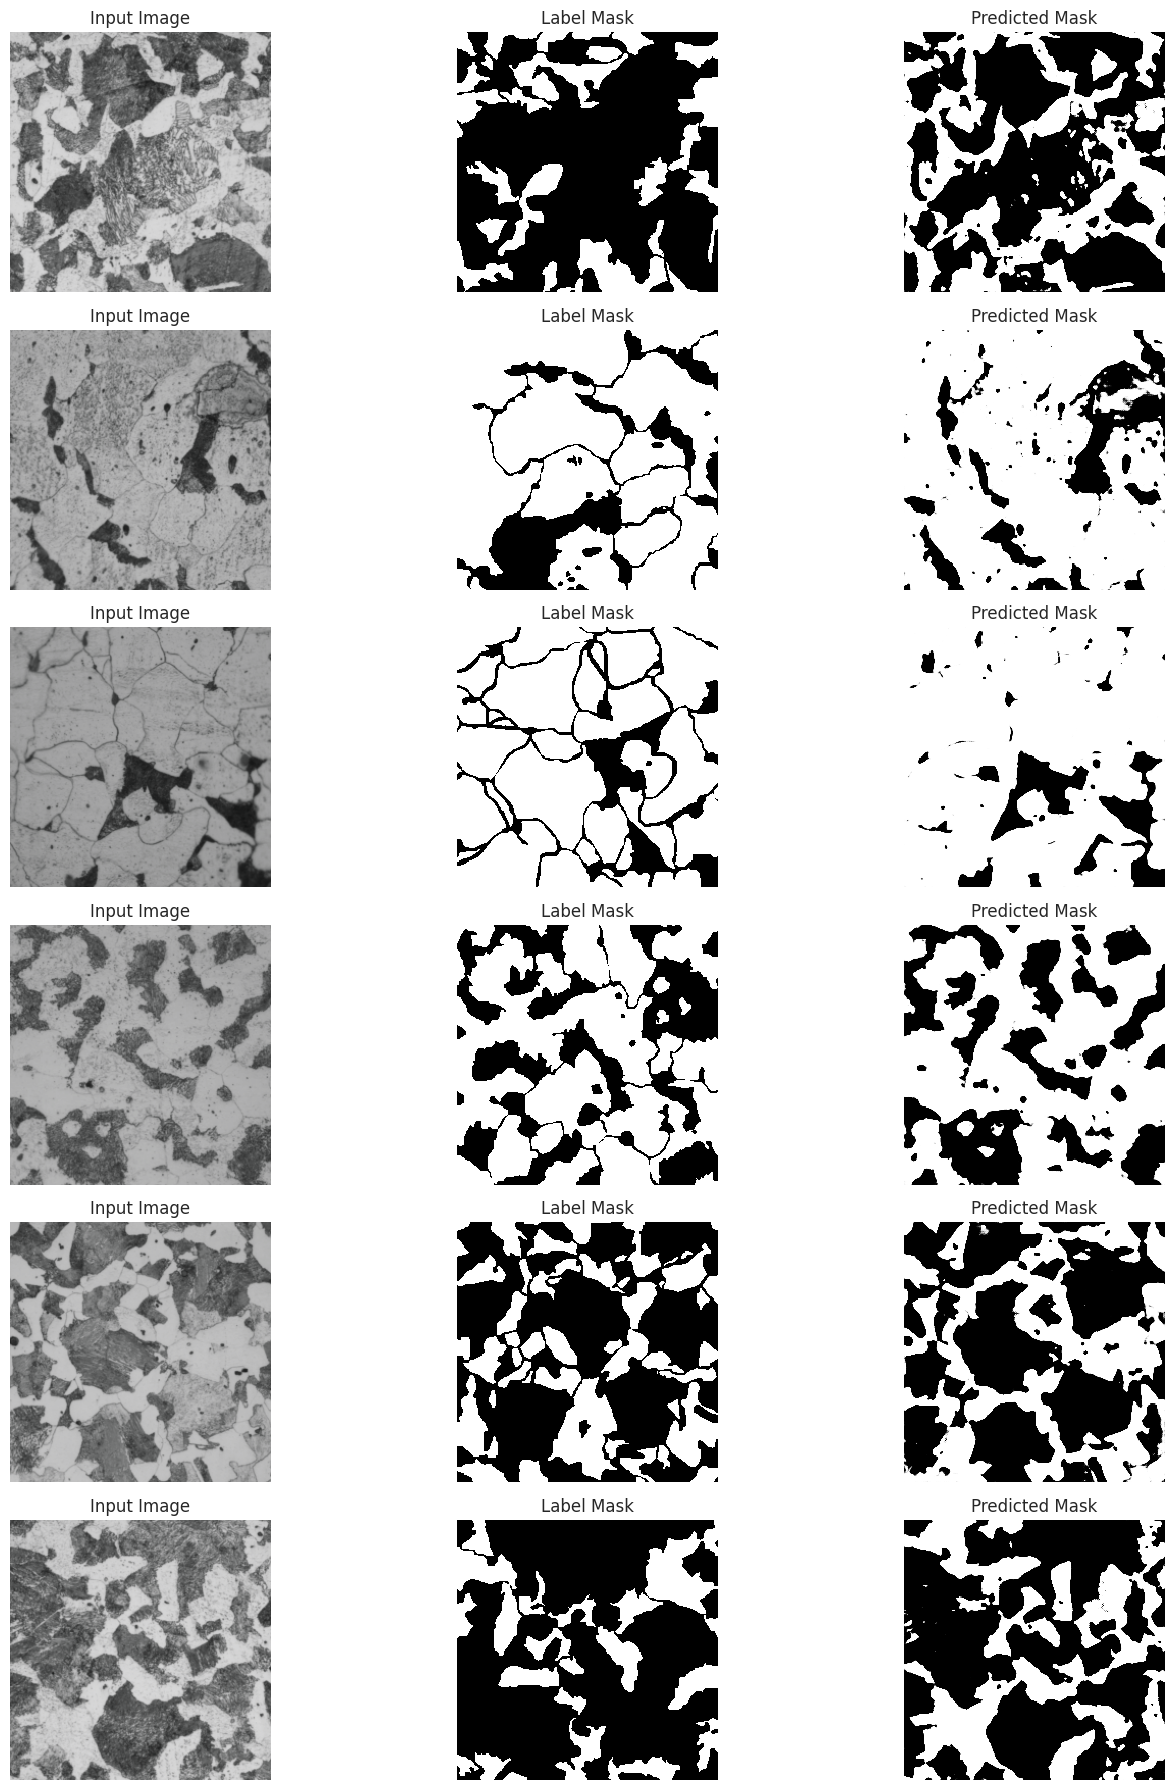

In [53]:
def visualize_predict(model, n_images, num_range):
    images = random.sample(range(0, num_range), n_images)
    print(images)
    # figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
    figure, ax = plt.subplots(nrows=len(images), ncols=3, figsize=(15, 18))
    
    with torch.no_grad():
        for data,mask in val_loader:
            data = torch.autograd.Variable(data, volatile=True).cuda()
            # data = torch.autograd.Variable(data, volatile=True).cpu().numpy()
            mask = torch.autograd.Variable(mask, volatile=True).cuda()
            # mask = torch.autograd.Variable(mask, volatile=True).cpu().numpy()
            o = model(data)
            break
    for i in range(0, len(images)):
        img_no = images[i]
        tm=o[i][0].data.cpu().numpy()
        img = data[i].data.cpu().numpy()
        msk = mask[i].data.cpu().numpy()
        img = format_image(img)
        msk = format_mask(msk)
        ax[i, 0].imshow(img)
        ax[i, 1].imshow(msk, interpolation="nearest", cmap="gray")
        ax[i, 2].imshow(tm, interpolation="nearest", cmap="gray")
        ax[i, 0].set_title(f"Input Image No.{img_no+1}")
        ax[i, 1].set_title(f"Label Mask No.{img_no+1}")
        ax[i, 2].set_title(f"Predicted Mask No.{img_no+1}")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()
        # 画像の保存
        plt.imsave(f"../tmp/Input_Image_No_{img_no+1}.png", img)
        plt.imsave(f"../tmp/Label_Mask_No_{img_no+1}.png", msk)
        plt.imsave(f"../tmp/Predicted_Mask_No_{img_no+1}.png", tm)
    plt.tight_layout()
    plt.show()

visualize_predict(model, 6, num_range)